# Obtaining structured web content and programmatic access

In this notebook we will learn how to make use of readily structured data through dedicated application programming interfaces (APIs), how to authenticate and how to properly design requests (also called "payload") in order to retrieve large datasets.

**Advantages** of APIs are that
- access is legal and in most cases clearly and transparently regulated (e.g. 10,000 calls per day)
- structuring through `requests` and `BeautifulSoup` not required
- Python packages that simplify server-client interaction are available

**Disadvantages** of APIs are that
- we have to learn how APIs work and how we should interact with them (each API has some peculiarities and documentation is usually good, but sometimes not so...)
- authentification may be required and access may not be free of charge 

We will
- obtain data of a public statistical office such as the IMF or World Bank through the `pandas-datareader`
- directly obtain a (ranking) table from a website such the [World Cube Association](https://www.worldcubeassociation.org/results/rankings/333/single)
- learn how to use the Destatis/GENESIS Online service and API
- learn how to use the Twitter API (in particular [Tweepy](https://www.tweepy.org/), a Python library for the Twitter API) and retrieve Tweets with GeoTags (i.e. coordinates) subject to specified geography and search terms
- conduct some small analyses and visualise the results appropriately

In [1]:
import pandas as pd

In [2]:
!pip install pandas-datareader --upgrade

In [3]:
from pandas_datareader import wb # imports world bank access
search = wb.search('GDP.*current.*US') # search for keyword
search

,id,name,unit,source,sourceNote,sourceOrganization,topics
9217,NV.SRV.DISC.CD,"Discrepancy in GDP, value added (current US$)",,Africa Development Indicators,This is the discrepancy included in the value ...,"b'World Bank national accounts data, and OECD ...",
9345,NY.GDP.DISC.CD,Discrepancy in expenditure estimate of GDP (cu...,,Africa Development Indicators,This is the discrepancy included in the ‘total...,"b'World Bank national accounts data, and OECD ...",
9356,NY.GDP.MKTP.CD,GDP (current US$),,World Development Indicators,GDP at purchaser's prices is the sum of gross ...,"b'World Bank national accounts data, and OECD ...",Economy & Growth
9375,NY.GDP.PCAP.CD,GDP per capita (current US$),,World Development Indicators,GDP per capita is gross domestic product divid...,"b'World Bank national accounts data, and OECD ...",Economy & Growth
9482,NYGDPMKTPSACD,"GDP,current US$,millions,seas. adj.,",,Global Economic Monitor,,b'',


In [4]:
df = wb.download(indicator = 'NY.GDP.MKTP.CD', country = ['DE', 'FR', 'IT'],
                start = 2000, end = 2019)
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 60 entries, ('Germany', '2019') to ('Italy', '2000')
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   NY.GDP.MKTP.CD  60 non-null     float64
dtypes: float64(1)
memory usage: 1.5+ KB


In [5]:
df.groupby('country').describe()

NY.GDP.MKTP.CD                                            \
                 count          mean           std           min   
country                                                            
France            20.0  2.391444e+12  5.039285e+11  1.362249e+12   
Germany           20.0  3.213212e+12  6.554315e+11  1.943145e+12   
Italy             20.0  1.907346e+12  3.611625e+11  1.143830e+12   

                                                                 
                  25%           50%           75%           max  
country                                                          
France   2.176030e+12  2.618880e+12  2.733605e+12  2.918383e+12  
Germany  2.836649e+12  3.409510e+12  3.730707e+12  3.963768e+12  
Italy    1.827731e+12  1.982686e+12  2.145770e+12  2.398857e+12

In [6]:
df2 = df.reset_index()
df2.head()

,country,year,NY.GDP.MKTP.CD
0,Germany,2019,3.861124e+12
1,Germany,2018,3.963768e+12
2,Germany,2017,3.682602e+12
3,Germany,2016,3.467498e+12
4,Germany,2015,3.356236e+12


In [7]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   country         60 non-null     object 
 1   year            60 non-null     object 
 2   NY.GDP.MKTP.CD  60 non-null     float64
dtypes: float64(1), object(2)
memory usage: 1.5+ KB


In [8]:
df2.columns = ['country', 'year', 'gdp'] # rename columns
df2.year = df2.year.astype(int) # numeric annual indicator
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   country  60 non-null     object 
 1   year     60 non-null     int32  
 2   gdp      60 non-null     float64
dtypes: float64(1), int32(1), object(1)
memory usage: 1.3+ KB


In [9]:
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [ ]:
# set(df2['country'])

In [10]:
traces = []

for country in df2['country'].unique():
    
    trace = go.Scatter(name = country, x = df2[df2['country'] == country]['year'],
                      y = df2[df2['country'] == country]['gdp'])
    
    traces.append(trace)
    
fig = go.Figure(data = traces)

fig.layout.update(title=go.layout.Title(

    text = 'Nominal GDP'

))

fig.layout.update(yaxis= go.layout.YAxis(title=go.layout.yaxis.Title(
                        text='in US$')));

fig.layout.update(xaxis = go.layout.XAxis(title = go.layout.xaxis.Title(text = 'Year'), rangeslider = dict(visible = True)));

iplot(fig, filename = 'Nominal_GDP')

The installation procedure of spatial libraries for Python (on Windows) can be quite tedious but [this answer](https://stackoverflow.com/questions/51095970/install-python-geopandas-failed/51560940#51560940) and [this detailed instruction](https://geoffboeing.com/2014/09/using-geopandas-windows/) make it straight forward. You 

In [11]:
import geopandas as gpd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16,9]

In [12]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

<AxesSubplot:>

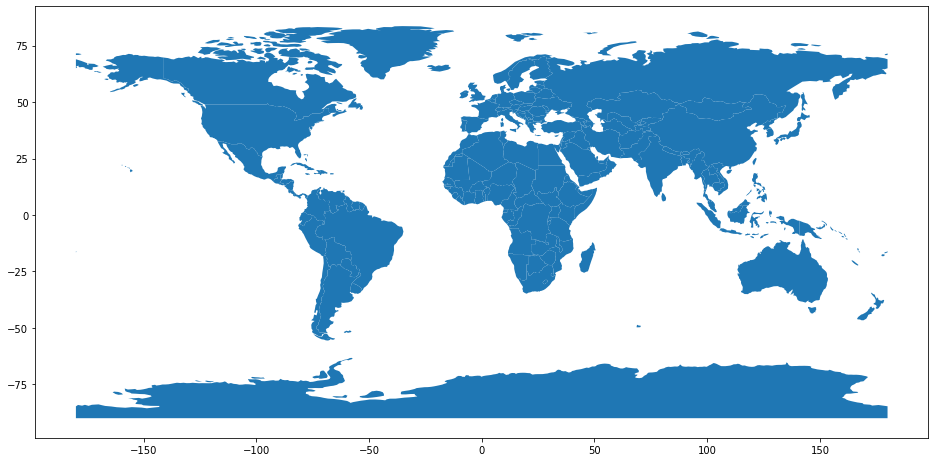

In [13]:
world.plot()

In [35]:
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [39]:
df = pd.read_csv("https://gist.githubusercontent.com/gerwolf/81ebb170eb25d4a13f2695db4520f90e/raw/7c24eb4a2b11f6d4c7ac38bdf3555dfc7da6823e/GDPpc_PPP.csv", sep = ";")
df['Country'] = df['Country'].str.replace('�',' ')
df['Country'] = df['Country'].str.replace('United States','United States of America')

In [41]:
df[df['Country'] == 'United States of America']

,Country,GDPpc_PPP
11,United States of America,"62,606"


In [43]:
final_geodf = df.merge(world, left_on='Country', right_on = 'name', how = 'left').dropna()

In [44]:
final_geodf['GDPpc_PPP'] = final_geodf['GDPpc_PPP'].str.replace(',','')

In [45]:
fig = go.Figure(data=[go.Choropleth(
    locations=final_geodf['iso_a3'], # Spatial coordinates
    z = final_geodf['GDPpc_PPP'].astype(float), # Data to be color-coded
#     locationmode = 'world', # set of locations match entries in `locations`
    colorscale = 'Reds',
    text=final_geodf['Country']
#     colorbar_title = "Millions USD",
)])

fig.layout.update(
    title_text = 'GDP per capita (2018, IMF)',
    geo_scope='world', # limite map scope to USA
);

iplot(fig, filename ="geomap")

In [51]:
fig = go.Figure(data=[go.Choropleth(
    locations=final_geodf[final_geodf['continent'] == 'Europe']['iso_a3'], # Spatial coordinates
    z = final_geodf[final_geodf['continent'] == 'Europe']['GDPpc_PPP'].astype(float), # Data to be color-coded
#     locationmode = 'world', # set of locations match entries in `locations`
    colorscale = 'Reds',
    text=final_geodf[final_geodf['continent'] == 'Europe']['Country']
#     colorbar_title = "Millions USD",
)])

fig.layout.update(
    title_text = 'GDP per capita (2018, IMF)',
    geo_scope='europe', # limite map scope to USA
);

iplot(fig, filename ="geomap")